In [293]:

import numpy as np
import pandas as pd

import seaborn as sns
from xgboost import XGBClassifier

from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression 
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, log_loss


In [294]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [295]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Carregamento e Primeira visão dos dados

In [296]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(f'Quantidade de linhas do Dataframe: {df.shape[0]}')
print(f'Quantidade de colunas do Dataframe: {df.shape[1]}')

Quantidade de linhas do Dataframe: 7043
Quantidade de colunas do Dataframe: 21


In [297]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Tratamento de Dados

In [298]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [299]:
# Substituindo o tipo de dado das variáveis que estão erradas
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [300]:
#Verificando a presença de valores nulos
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [301]:
#Removendo linhas com valores nulos pois essa categoria de totalPago é impossível de ser 0
df.dropna(inplace = True)

## Estatística Descritiva dos dados

In [302]:
num_attributes = df.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

In [303]:
# Medidas de tendência central - média, mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# Medidas de dispersão - 'min', 'max', 'range', 'desvio padrão','skew', 'kurtosis'
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['Colunas', 'min', 'max', 'range', 'media', 'mediana', 'desvio padrão','skew', 'kurtosis']
m

,Colunas,min,max,range,media,mediana,desvio padrão,skew,kurtosis
0,tenure,1.00,72.00,71.0,32.421786,29.000,24.543514,0.237731,-1.387823
1,MonthlyCharges,18.25,118.75,100.5,64.798208,70.350,30.083835,-0.222103,-1.256156
2,TotalCharges,18.80,8684.80,8666.0,2283.300441,1397.475,2266.610181,0.961642,-0.231799


Pela avaliação dos dados de TotalCharges podemos notar uma grande diferença entre a média e a mediana dos dados, isso provavelmente foi ocasionado pela presença de valores discrepantes. Por isso para entender melhor a distribuição desses dados, iremos avaliar o Gráfico de boxplot e um histograma dessa coluna

c:\Users\Igor\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


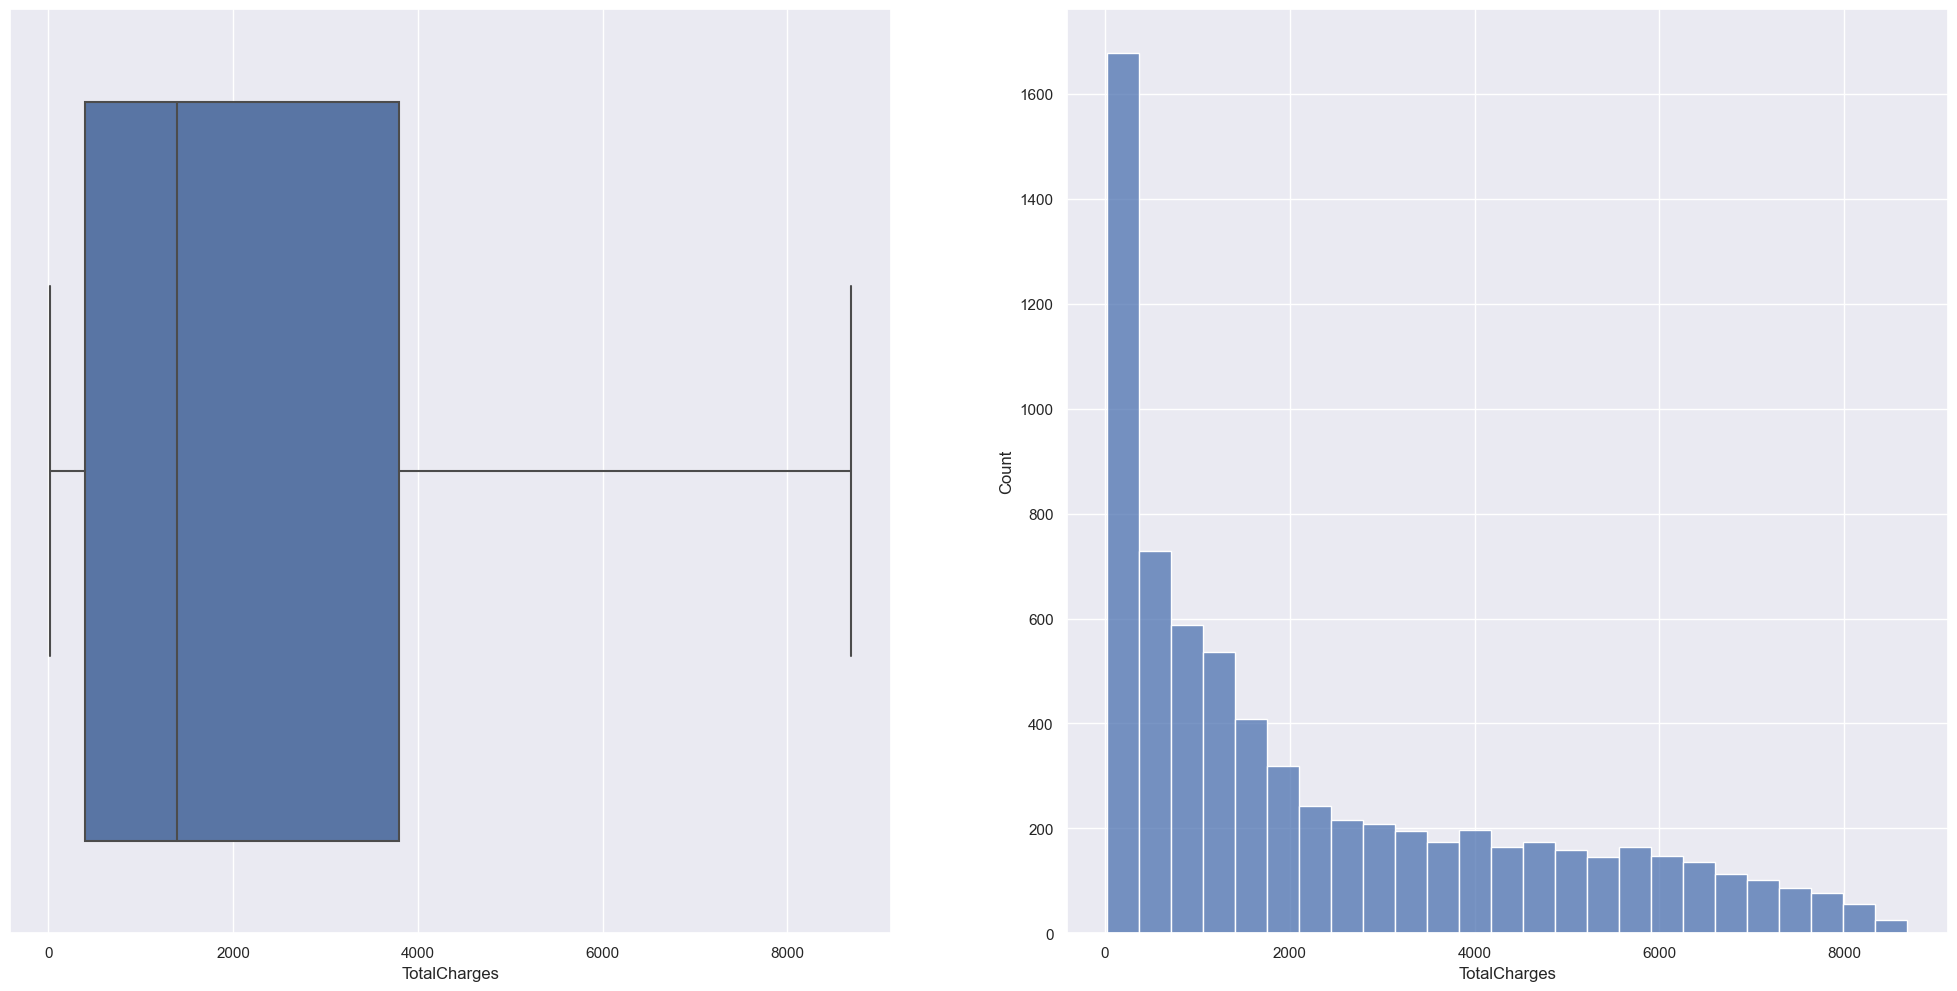

In [304]:
lista_de_colunas_numericas = ['tenure','MonthlyCharges','TotalCharges']

# Configurando o primeiro subplot com o boxplot
plt.subplot(1, 2, 1) # 1 linha, 2 colunas, primeiro subplot
sns.boxplot(df['TotalCharges'])

# Configurando o segundo subplot com o histograma
plt.subplot(1, 2, 2) # 1 linha, 2 colunas, segundo subplot
sns.histplot(df['TotalCharges'])

# Exibindo o gráfico
plt.show()

In [305]:
#Analisando a estatística descritiva das variáveis categóricas, podemos analisar principalmente a moda e a frequência.
cat_attributes.describe().T

,count,unique,top,freq
customerID,7032,7032,7590-VHVEG,1
gender,7032,2,Male,3549
SeniorCitizen,7032,2,0,5890
Partner,7032,2,No,3639
Dependents,7032,2,No,4933
PhoneService,7032,2,Yes,6352
MultipleLines,7032,3,No,3385
InternetService,7032,3,Fiber optic,3096
OnlineSecurity,7032,3,No,3497
OnlineBackup,7032,3,No,3087


### Modelagem 


### Pre-Processamento

Utilizando Pipeline para realizar as transformações necessária, com esse método a chance de ocorrer Data Leakage diminui e o mais importante é a organização que trás para o código, deixando a manutenção fácil para o futuro 


In [306]:
df = df.copy()
df.Churn = np.where(df['Churn']== "Yes",1,0)

In [307]:
# Separar os dados em treinamento e teste
X = df.drop(['Churn','customerID'],axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Separar em variáveis categóricas e numéricas

variaveis_categoricas = [coluna for coluna in X_train.columns if X_train[coluna].dtype.name == 'object']
variaveis_numericas = [coluna for coluna in X_train.columns if coluna not in variaveis_categoricas]

t = [('str_categoricas', OneHotEncoder(), variaveis_categoricas),
     ('int_numericas', StandardScaler(), variaveis_numericas)]

preprocessor = ColumnTransformer(transformers=t)

validacao_cruzada = KFold(n_splits=10, shuffle=True, random_state=42)

# Defina a lista de modelos de classificação
models = [    DecisionTreeClassifier(),
              RandomForestClassifier(),
              LogisticRegression(),
              XGBClassifier(),
              GradientBoostingClassifier()]

# Crie um dicionário para armazenar os resultados da validação cruzada
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr'),
    'log_loss': make_scorer(log_loss, needs_proba=True, greater_is_better=False)
}
#Criação de listas para incluir as avaliações dos modelos 
results = {'Modelo': []}
for key in scoring.keys():
    results[key] = []

# Itere por cada modelo, defina o classificador dentro do pipeline e rode a validação cruzada
for model in models:
    pipe_transformer = Pipeline(steps=[('preprocessor', preprocessor), ('clf', model)])
    cv_results = cross_validate(pipe_transformer, X_test, y_test, cv=validacao_cruzada, scoring=scoring)
    results['Modelo'].append(type(model).__name__)
    for key in scoring.keys():
        results[key].append(cv_results['test_'+key].mean())

# Crie um DataFrame com os resultados da validação cruzada
df = pd.DataFrame(results)
df.sort_values('roc_auc', ascending= False)

,Modelo,accuracy,precision,recall,f1,roc_auc,log_loss
2,LogisticRegression,0.798785,0.790079,0.798785,0.790817,0.708530,-0.421237
4,GradientBoostingClassifier,0.793179,0.783592,0.793179,0.783574,0.696980,-0.431992
3,XGBClassifier,0.768631,0.759307,0.768631,0.761093,0.675486,-0.548979
1,RandomForestClassifier,0.780256,0.767980,0.780256,0.768317,0.674887,-0.557498
0,DecisionTreeClassifier,0.717778,0.728120,0.717778,0.721512,0.651522,-10.142141


Este foi um código para colocar em prática as técnicas de Pipelines, pois facilitam muito o processo de gerar um modelo de Machine Learning.

Neste caso, podemos entender que para o caso de Churn o modelo de Regressão logística obteve a melhor performance com os Hiperparâmetros padrões.

O modelo possui uma alta *Precisão*, isso mostra que quando o modelo classifica o cliente como possível Churn, ele tem 79% de chance de acertar essa estimativa

Com o *Recall* podemos interpretar como taxa de detecção, de todos os exemplos de Churn, quanto o modelo conseguiu prever? nesse caso também foi um bom resultado de 80%

